<img src="NotebookAddons/blackboard-banner.png" width="100%" />
<font face="Calibri">
<br>
    <font size="5"> <b>Change Point Detection in SAR Amplitude Time Series Data</b></font>

<br>
<font size="4"> <b> Franz J Meyer; University of Alaska Fairbanks & Josef Kellndorfer, <a href="http://earthbigdata.com/" target="_blank">Earth Big Data, LLC</a> </b> <br>
<img src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right" />
</font>

<font size="3"> This notebook applies Change Point Detection on a deep multi-temporal SAR image data stack acquired by Sentinel-1. Specifically, the lab applies the method of <i>Cumulative Sums</i> to perform change detection on a 60 image deep Sentinel-1 data stack over Niamey, Niger.  

<b>In this notebook we introduce the following data analysis concepts:</b>
<br>
- The concepts of time series slicing by month, year, and date.
- The concepts and workflow of Cumulative Sum-based change point detection.
- The identification of change dates for each identified change point.

</font>
</font>

<hr>
<font face="Calibri" size="5" color="red"> <b>Important Note about JupyterHub</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.</b> </font>


In [1]:

%%javascript
var kernel = Jupyter.notebook.kernel;
var command = ["notebookUrl = ",
               "'", window.location, "'" ].join('')
kernel.execute(command)

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import Markdown
from IPython.display import display

user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/rtc_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "rtc_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select the "rtc_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "rtc_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3"> Our first step is to <b>import the necessary python libraries into your Jupyter Notebook:</b></font>

In [3]:
%%capture
import os 
from pathlib import Path
from copy import deepcopy

import pandas as pd
from osgeo import gdal # for Info
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.patches as patches

import asf_notebook as asfn
asfn.jupytertheme_matplotlib_format()

<hr>
<font face="Calibri">

<font size="5"> <b> 1. Load Data Stack for this Lab </b> </font> <img src="NotebookAddons/Lab8-Agrhymet.JPG" width="400" align="right" /> 

<font size="3"> This notebook will be using a 60-image deep C-band Sentinel-1 SAR data stack over Niamey, Niger to demonstrate the concepts of time series change detection. The data are available to us through the services of the <a href="https://www.asf.alaska.edu/" target="_blank">Alaska Satellite Facility</a>. 

Specifically we will use a small image segment over the campus of <a href="http://www.agrhymet.ne/eng/" target="_blank">AGRHYMET Regional Centre</a>, a regional organization supporting West Africa in the use or remote sensing.  

This site was picked as we had information about construction going on at this site sometime in the 2015 - 2017 time frame. Land was cleared and a building was erected. In this notebook, we will see if we can detect the construction activity and if we are able to determine when construction began and when it ended.

In this case, we will <b>retrieve the relevant data</b> from an <a href="https://aws.amazon.com/" target="_blank">Amazon Web Service (AWS)</a> cloud storage bucket.</font></font>
<hr>

<font face="Calibri" size="4"> <b> 1.1 Download The Data: </b> </font>
<br><br>
<font face="Calibri" size="3"> Before we download anything, <b>create a working directory for this analysis and change into it:</b> </font>

In [4]:
path = Path("/home/jovyan/notebooks/SAR_Training/English/Master/data_Change_Detection_Amplitude_Time_Series_Example")

if not path.is_dir():
    path.mkdir()

<font face="Calibri" size="3"><b>Download the data from the AWS bucket:</b> </font>

In [5]:
!aws --region=us-east-1 --no-sign-request s3 cp s3://asf-jupyter-data/Niamey.zip $path/Niamey.zip

download: s3://asf-jupyter-data/Niamey.zip to data_Change_Detection_Amplitude_Time_Series_Example/Niamey.zip


<font face="Calibri" size="3"><b>Unzip the file and clean up:</b> </font>

In [6]:
f = path/Path("Niamey.zip")
asfn.asf_unzip(str(path), str(f))

if f.is_file():
    f.unlink()

Extracting: /home/jovyan/notebooks/SAR_Training/English/Master/data_Change_Detection_Amplitude_Time_Series_Example/Niamey.zip


<hr>
<font face="Calibri" size="4"> <b> 1.2 Switch to the Data Directory: </b> </font>
<br><br>
<font face="Calibri" size="3"> The following lines set variables that capture path variables needed for data processing. <b>Change into the unzipped /cra directory and define variables for names of the files containing data and image information:</b> </font>

In [51]:
cra_path = f.cwd().joinpath('data_Change_Detection_Amplitude_Time_Series_Example', 'cra')

date_file = None
image_file = None

if asfn.path_exists(str(cra_path)):
    date_file = str(list(cra_path.rglob('S32631X402380Y1491460sS1_A_vv_0001_A_mtfil.dates')).pop())
    image_file = str(list(cra_path.rglob('S32631X402380Y1491460sS1_A_vv_0001_A_mtfil.vrt')).pop())

<hr>
<font face="Calibri" size="4"> <b> 1.3 Assess Image Acquisition Dates </b> </font> 

<font face="Calibri" size="3"> Before we start analyzing the available image data, we want to examine the content of our data stack. <b>To do so, we read the image acquisition dates for all files in the time series and create a *pandas* date index:</b> </font>

In [52]:
with open(date_file, 'r') as d:
    dates = d.readlines()
time_index = pd.DatetimeIndex(dates)
j = 1
print('Bands and dates for', image_file)
for i in time_index:
    print("{:4d} {}".format(j, i.date()), end=' ')
    j += 1
    if j%5 == 1: print()

Bands and dates for /home/jovyan/notebooks/SAR_Training/English/Master/data_Change_Detection_Amplitude_Time_Series_Example/cra/S32631X402380Y1491460sS1_A_vv_0001_A_mtfil.vrt
   1 2015-04-03    2 2015-11-17    3 2015-11-29    4 2015-12-11    5 2015-12-23 
   6 2016-01-04    7 2016-01-28    8 2016-02-09    9 2016-03-04   10 2016-03-16 
  11 2016-03-28   12 2016-04-09   13 2016-04-21   14 2016-05-03   15 2016-05-15 
  16 2016-05-27   17 2016-06-08   18 2016-07-02   19 2016-07-14   20 2016-07-26 
  21 2016-08-07   22 2016-08-19   23 2016-08-31   24 2016-09-12   25 2016-09-24 
  26 2016-10-06   27 2016-10-18   28 2016-10-30   29 2016-11-11   30 2016-11-23 
  31 2016-12-05   32 2016-12-17   33 2016-12-29   34 2017-01-10   35 2017-01-22 
  36 2017-02-03   37 2017-02-15   38 2017-02-27   39 2017-03-11   40 2017-03-23 
  41 2017-04-04   42 2017-04-16   43 2017-04-28   44 2017-05-10   45 2017-05-22 
  46 2017-06-03   47 2017-06-15   48 2017-06-27   49 2017-07-09   50 2017-07-21 
  51 2017-08-02 

<hr>
<font face="Calibri" size="4"> <b> 1.4 Read in the Data Stack </b> </font> 

<font face="Calibri" size="3"> We read in the time series raster stack from the entire data set. </font>

In [53]:
raster_stack = gdal.Open(image_file).ReadAsArray()

<hr>
<font face="Calibri" size="4"> <b> 1.5 Lay the groundwork for saving plots and level-3 products.</b> </font> 
<br><br>
<font face="Calibri" size="3"><b>Create a directory in which to store our output, and move into it:</b></font> 

In [147]:
"""
Create new dir to store output w/o changing directories.

No need to change into new directory to avoid moving around dirs.
Prehaps keep path location in new variable?
"""
product_path = 'data_Change_Detection_Amplitude_Time_Series_Example/plots_and_products'
asfn.new_directory(product_path)

# os.chdir(path)
# product_path = 'plots_and_products'
# asfn.new_directory(product_path)
# if asfn.path_exists(product_path) and os.getcwd() != f"{path}/{product_path}":
#     os.chdir(product_path)
# print(f"Current working directory: {os.getcwd()}")

data_Change_Detection_Amplitude_Time_Series_Example/plots_and_products already exists.


<font face="Calibri" size="3">We will need the upper-left and lower-right corner coordinates when saving our products as GeoTiffs. In this situation, you have been given a pre-subset vrt image stack. 
<br><br>
<b>Retrieve the corner coordinates from the vrt using gdal.Info():</b></font> 

In [55]:
vrt = gdal.Open(image_file)
vrt_info = gdal.Info(vrt, format='json')
coords = [vrt_info['cornerCoordinates']['upperLeft'], vrt_info['cornerCoordinates']['lowerRight']]
print(coords)

[[402380.0, 1492220.0], [403260.0, 1491460.0]]


<font face="Calibri" size="3"><b>Retrieve the utm zone from the vrt:</b></font> 

In [56]:
utm_zone = vrt_info['coordinateSystem']['wkt'].split(',')[-1][0:-2]
print(f"utm zone: {utm_zone}")

utm zone: 32631


<font face="Calibri" size="3"><b>Write a function to convert our plots into GeoTiffs:</b></font> 

In [57]:
# do not include a file extension in out_filename
# extent must be in the form of a list: [[upper_left_x, upper_left_y], [lower_right_x, lower_right_y]]
def geotiff_from_plot(source_image, out_filename, extent, utm_zone, cmap=None, vmin=None, vmax=None, interpolation=None, dpi=300):
    plt.figure()
    plt.axis('off')
    plt.imshow(source_image, cmap=cmap, vmin=vmin, vmax=vmax, interpolation=interpolation)
    temp = f"{out_filename}_temp.png"
    plt.savefig(temp, dpi=dpi, transparent='true', bbox_inches='tight', pad_inches=0)

    cmd = f"gdal_translate -of Gtiff -a_ullr {extent[0][0]} {extent[0][1]} {extent[1][0]} {extent[1][1]} -a_srs EPSG:{utm_zone} {temp} {out_filename}.tiff"
    !{cmd}
    try:
        os.remove(temp)
    except FileNotFoundError:
        pass

<br>
<hr><hr>
<font face="Calibri" size="5"> <b> 2. Plot the Global Means of the Time Series </b> </font> 

<font face="Calibri" size="3"> To accomplish this task, <b>complete the following steps:</b>
<ol>
    <li>Conversion to power-scale</li>
    <li>Compute mean values</li>
    <li>Convert to dB-scale</li>
    <li>Create time series of means using Pandas</li>
    <li>Plot time series of means</li>
</ol>
</font> 
<br>
<font face="Calibri" size="3"><b>Convert to Power-scale:</b></font>

In [58]:
caldB = -83
calPwr = np.power(10.0, caldB/10.0)
raster_stack_pwr = np.power(raster_stack, 2.0) * calPwr

<font face="Calibri" size="3"><b>Compute means:</b></font>

In [59]:
rs_means_pwr = np.mean(raster_stack_pwr, axis=(1, 2))

<font face="Calibri" size="3"><b>Convert to dB-scale:</b></font>

In [60]:
rs_means_dB = 10.0 * np.log10(rs_means_pwr)

<font face="Calibri" size="3"><b>Make a pandas time series object:</b></font>

In [61]:
ts = pd.Series(rs_means_dB,index=time_index)

<font face="Calibri" size="3"><b>Use pandas to plot the time series object with band numbers as data point labels. Save the plot as a png (time_series_means.png):</b></font>

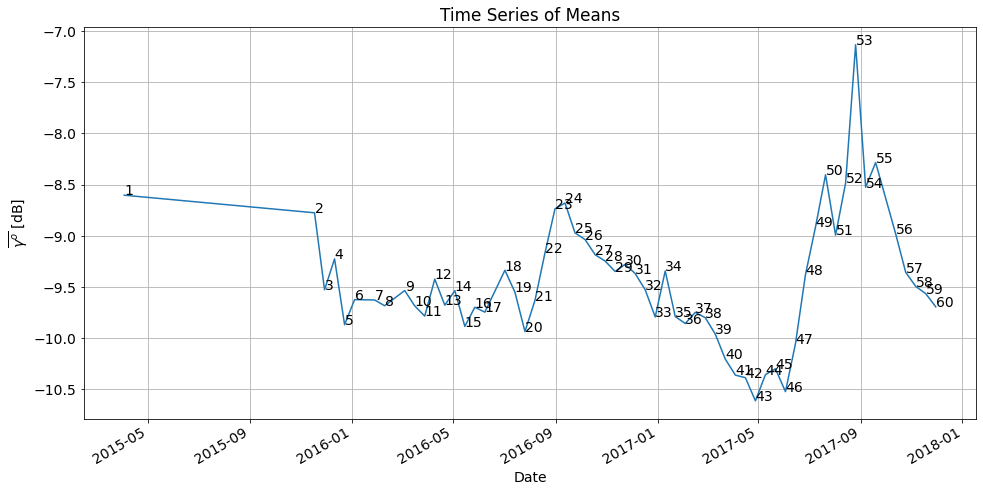

In [62]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(16, 8))
plt.title(f"Time Series of Means")
ts.plot()
xl = plt.xlabel('Date')
yl = plt.ylabel('$\overline{\gamma^o}$ [dB]')
for xyb in zip(ts.index, rs_means_dB, range(1, len(ts)+1)):
    plt.annotate(xyb[2], xy=xyb[0:2])
plt.grid()
plt.savefig('time_series_means.png', dpi=72)

<br>
<hr>
<font face="Calibri" size="5"> <b> 3. Generate Time Series for Point Locations or Subsets</b> </font> 

<font face="Calibri" size="3"> In python, we can use the matrix slicing tools (similar to those used in Matlab) to obtain subsets of the data. For example, to pick one pixel at a line/pixel location and obtain all band values, use:

>  [:,line,pixel] notation. 

Or, if we are interested in a subset at a offset location we can use:

> [:,yoffset:(yoffset+yrange),xoffset:(xoffset+xrange)]

In the section below we will learn how to generate time series plots for point locations (pixels) or areas (e.g. a 5x5 window region). To show  individual bands, we define a <i>show_image</i> function which incorporates the matrix slicing from above.

</font> 

<hr>
<font face="Calibri" size="4"> <b> 3.1 Plotting Time Series for Subset </b> </font> 

<font face="Calibri" size="3"><b>Write a function to plot the calibrated time series for a pre-defined subset:</b></font>

In [63]:
# Preconditions:
# raster_stack must be a stack of images in SAR power units
# time_index must be a pandas date-time index
# band_number must represent a valid bandnumber in the raster_stack
def show_image(raster_stack, time_index, band_number, output_filename=None, subset=None, vmin=None, vmax=None):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # If vmin or vmax are None we use percentiles as limits:
    if vmin == None:
        vmin = np.percentile(raster_stack[band_number-1].flatten(), 5)
    if vmax == None:
        vmax = np.percentile(raster_stack[band_number-1].flatten(), 95)

    ax1.imshow(raster_stack[band_number-1], cmap='gray', vmin=vmin, vmax=vmax)
    ax1.set_title(f'Image Band {band_number} {time_index[band_number-1].date()}')
    if subset == None:
        bands, ydim, xdim = raster_stack.shape
        subset = (0, 0, xdim, ydim)
        
    ax1.add_patch(patches.Rectangle((subset[0], subset[1]), subset[2], subset[3], fill=False, edgecolor='red'))
    ax1.xaxis.set_label_text('Pixel')
    ax1.yaxis.set_label_text('Line')
    ax1.legend(['Subset AOI'], loc='best')
    
    ts_pwr = np.mean(raster_stack[:, subset[1]:(subset[1]+subset[3]), subset[0]:(subset[0]+subset[2])], axis=(1,2))
    ts_dB = 10.0 * np.log10(ts_pwr)
    ax2.plot(time_index, ts_dB)
    ax2.yaxis.set_label_text('$\gamma^o$ [dB]')
    ax2.set_title('$\gamma^o$ Backscatter Time Series')
    # Add a vertical line for the date where the image is displayed
    ax2.axvline(time_index[band_number-1], color='green')
    ax2.legend(['Time Series', f'Band {band_number} Date'], loc='best')
    plt.grid()

    fig.autofmt_xdate()
    
    if output_filename:
        plt.savefig(output_filename, dpi=72)
        print(f"Saved plot: {output_filename}")

<font face="Calibri" size="3">Call show_image() on different bands to compare the information content of different time steps in our area of interest.
<br><br>
 <b>Call show_image() on band number 24:</b></font>

Saved plot: band_24.png


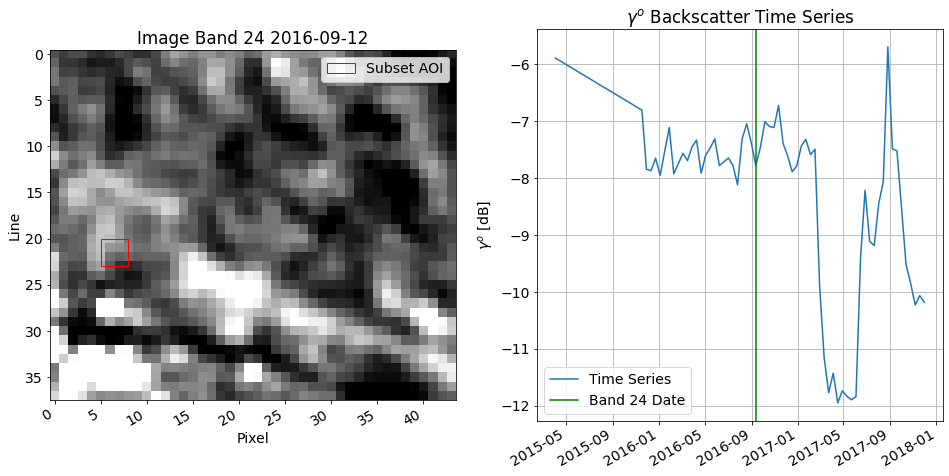

In [64]:
band_number = 24 
subset = [5, 20, 3, 3]
show_image(raster_stack_pwr, time_index, band_number, subset=subset, output_filename=f"band_{band_number}.png")

<font face="Calibri" size="3"><b>Call show_image() on band number 43:</b></font>

Saved plot: band_43.png


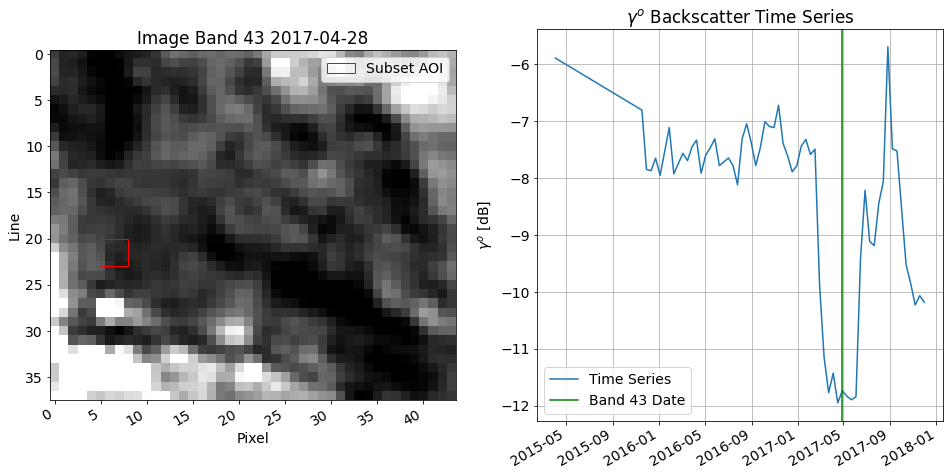

In [65]:
band_number = 43
show_image(raster_stack_pwr, time_index, band_number, subset=subset, output_filename=f"band_{band_number}.png")

<hr>
<font face="Calibri" size="4"> <b> 3.2 Helper Function to Generate a Time Series Object </b> </font> 

<font face="Calibri" size="3"><b>Write a function that creates an object representing the time series for an image subset:<b></font>

In [66]:
# Extract the means along the time series axes
# raster shape is time steps, lines, pixels. 
# With axis=1,2, we average lines and pixels for each time step (axis 0)
# returns pandas time series object
def timeSeries(raster_stack_pwr, time_index, subset, ndv=0.0):
    raster = raster_stack_pwr.copy()
    if ndv != np.nan:
        raster[np.equal(raster, ndv)] = np.nan
    ts_pwr = np.nanmean(raster[:,subset[1]:(subset[1]+subset[3]), subset[0]:(subset[0]+subset[2])], axis=(1, 2))
    # convert the means to dB
    ts_dB = 10.0 * np.log10(ts_pwr)
    # make the pandas time series object
    ts = pd.Series(ts_dB, index=time_index)
    return ts

<font face="Calibri" size="3"><b>Call timeSeries() to make a time series object for the chosen subset:</b></font>

In [67]:
ts = timeSeries(raster_stack_pwr, time_index, subset)

<font face="Calibri" size="3"><b>Plot the time series object:</b></font>

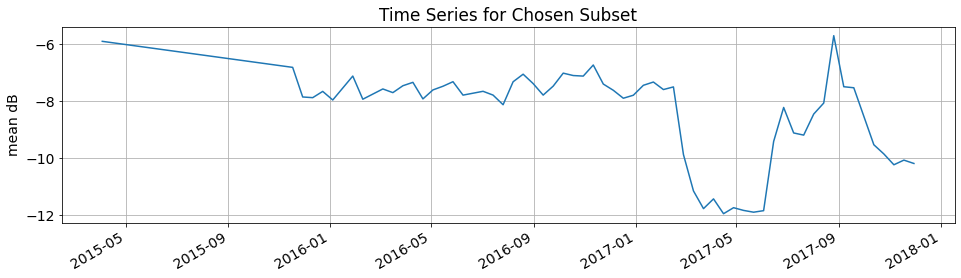

In [68]:
fig = ts.plot(figsize=(16, 4))
fig.yaxis.set_label_text('mean dB')
fig.set_title('Time Series for Chosen Subset')
plt.grid()

<br>
<hr>
<font face="Calibri" size="5"> <b> 4. Create Seasonal Subsets of Time Series Records</b> </font> 

<font face="Calibri" size="3"> Let's expand upon SAR time series analysis. Often it is desirable to subset time series by season or months to compare data acquired under similar weather/growth/vegetation cover conditions. For example, in analyzing C-Band backscatter data, it might be useful to limit comparative analysis to dry season observations only as soil moisture might confuse signals during the wet seasons. To subset time series along the time axis we will make use of the following <i>Pandas</i> datatime index tools:
<ul>
    <li>month</li>
    <li>day of year</li> 
</ul>
<br>
<b>Extract a hectare-sized area around our subset location (5,20,5,5):</b></font> 

In [69]:
subset = (5, 20, 5, 5)
time_series_1 = timeSeries(raster_stack_pwr, time_index, subset)

<font face="Calibri" size="3"><b>Convert the time series to a pandas DataFrame</b> to allow for more processing options.</font>

In [70]:
data_frame = pd.DataFrame(time_series_1, index=ts.index, columns=['g0'])

<font face="Calibri" size="3"><b>Label the data value column as 'g0' for $\gamma^0$ and plot the time series backscatter profile:</b></font>

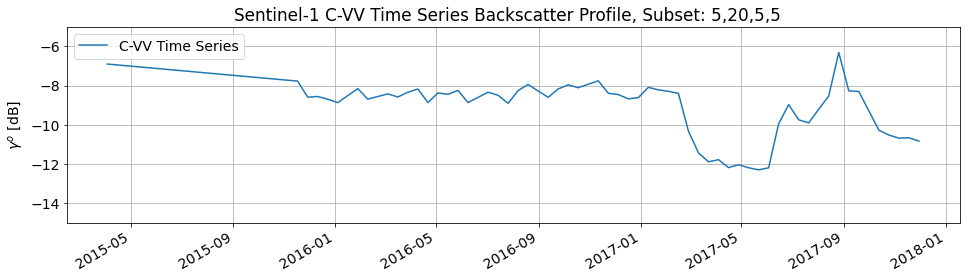

In [71]:
ylim = (-15, -5)
data_frame.plot(figsize=(16, 4))
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile, Subset: 5,20,5,5  ')
plt.ylabel('$\gamma^o$ [dB]')
plt.ylim(ylim)
_ = plt.legend(["C-VV Time Series"])
plt.grid()

<hr>
<font face="Calibri" size="4"><b> 4.1 Change Start Date of Time Series to November 2015 </b></font> 
<br><br>
<font face="Calibri" size="3"><b>Plot the cropped time series and save it as a png (time_series_backscatter_profile.png):</b></font>

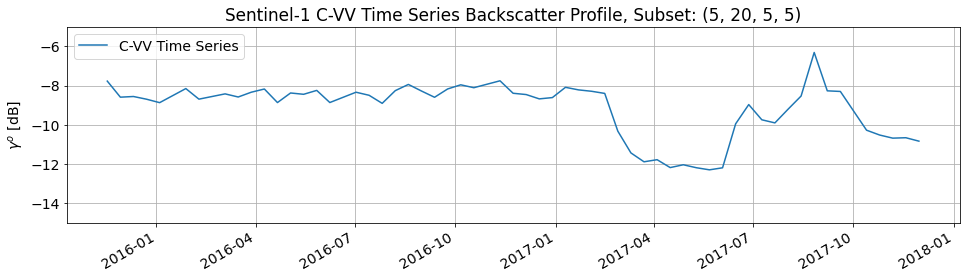

In [72]:
data_frame_sub1 = data_frame[data_frame.index>'2015-11-01']
# Plot
data_frame_sub1.plot(figsize=(16, 4))
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile, Subset: {}'.format(subset))
plt.ylabel('$\gamma^o$ [dB]')
plt.ylim(ylim)
_ = plt.legend(["C-VV Time Series"])
plt.grid()
plt.savefig('time_series_backscatter_profile', dpi=72)

<hr>
<font face="Calibri" size="4"> <b> 4.2 Subset Time Series by Months </b> </font> 

<font face="Calibri" size="3">Using the Pandas <i>DateTimeIndex</i> object index.month and numpy's logical_and function, we can easily subset the time series by month:
<br><br>
<b>Create subset data_frames. In one, replace the data from June-February with NaNs. In the other, replace the data from March-May with NaNs:</b></font>

In [73]:
data_frame_sub2 = deepcopy(data_frame_sub1)
for index, row in data_frame_sub2.iterrows():
    if index.month < 3 or index.month > 5:
        row['g0'] = np.nan
        
data_frame_sub3 = deepcopy(data_frame_sub1)
for index, row in data_frame_sub3.iterrows():
    if index.month > 2 and index.month < 6:
        row['g0'] = np.nan

<font face="Calibri" size="3"><b>Plot the time series backscatter profile for March - May. Save the plot as a png (march2may_time_series_backscatter_profile.png):</b></font>

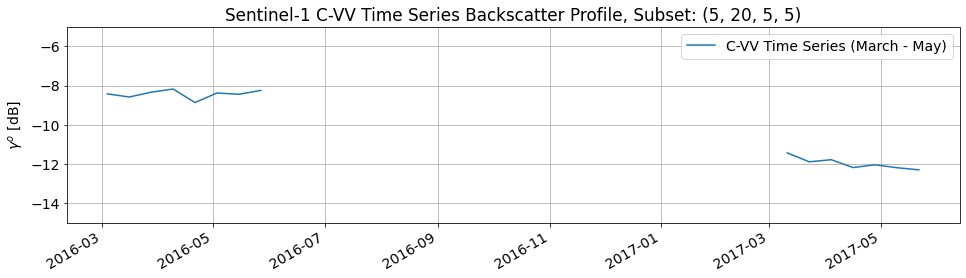

In [74]:
# Plot
fig, ax = plt.subplots(figsize=(16, 4))
data_frame_sub2.plot(ax=ax)
plt.title(f'Sentinel-1 C-VV Time Series Backscatter Profile, Subset: {subset}')
plt.ylabel('$\gamma^o$ [dB]')
plt.ylim(ylim)
_ = plt.legend(["C-VV Time Series (March - May)"], loc='best')
plt.grid()
plt.savefig('march2may_time_series_backscatter_profile', dpi=72)

<font face="Calibri" size="3"> Using numpy's **invert** function, we can invert a selection. In this example, we extract all other months from the time series.
<br><br>
<b>Plot the time series backscatter profile for June - Feburary. Save the plot as a png (june2feb_time_series_backscatter_profile.png):</b></font>

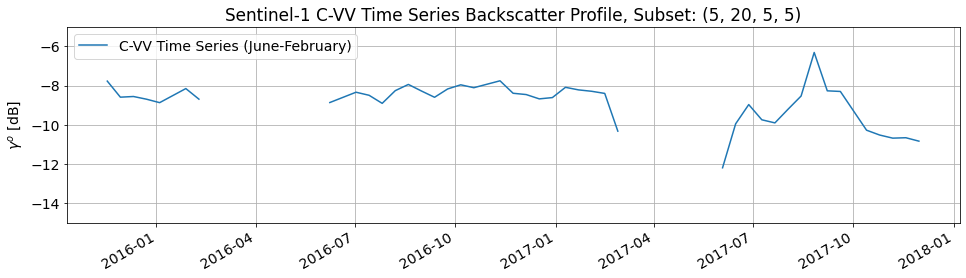

In [75]:
# Plot
fig, ax = plt.subplots(figsize=(16, 4))
data_frame_sub3.plot(ax=ax)
plt.title(f'Sentinel-1 C-VV Time Series Backscatter Profile, Subset: {subset}')
plt.ylabel('$\gamma^o$ [dB]')
plt.ylim(ylim)
_ = plt.legend(["C-VV Time Series (June-February)"], loc='best')
plt.grid()
plt.savefig('june2feb_time_series_backscatter_profile', dpi=72)

<hr>
<font face="Calibri" size="4"> <b> 4.3 Split Time Series by Year to Compare Year-to-Year Patterns </b> </font> 

<font face="Calibri" size="3"> Sometimes it is useful to compare year-to-year $\sigma^0$ values to identify changes in backscatter characteristics. This helps to distinguish true change from seasonal variability.
<br><br>
    <b>Split the time series into different years:</b></font>

In [76]:
data_frame_by_year = data_frame_sub1.groupby(pd.Grouper(freq="Y"))

<font face="Calibri" size="3"><b>Plot the split time series. Save the plot as a png (yearly_time_series_backscatter_profile.png):</b></font>

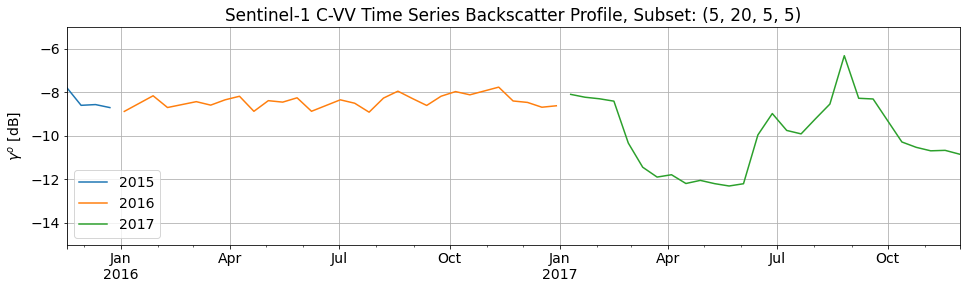

In [77]:
fig, ax = plt.subplots(figsize=(16, 4))
for label, df in data_frame_by_year:
    df.g0.plot(ax=ax, label=label.year)
plt.legend()
# data_frame_by_year.plot(ax=ax)
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile, Subset: {}'.format(subset))
plt.ylabel('$\gamma^o$ [dB]')
plt.ylim(ylim)
plt.grid()
plt.savefig('yearly_time_series_backscatter_profile', dpi=72)

<hr>
<font face="Calibri" size="4"> <b> 4.4 Create a Pivot Table to Group Years and Sort Data for Plotting Overlapping Time Series </b> </font> 

<font face="Calibri" size="3"> Pivot Tables are  a technique in data processing. They enable a person to arrange and rearrange (or "pivot") statistics in order to draw attention to useful information. To do so, we first <b>add columns for day-of-year and year to the data frame:</b>
</font>

In [78]:
# Add day of year
data_frame_sub1 = data_frame_sub1.assign(doy=data_frame_sub1.index.dayofyear)
# Add year
data_frame_sub1 = data_frame_sub1.assign(year=data_frame_sub1.index.year)

<font face="Calibri" size="3"><b>Create a pivot table which has day-of-year as the index and years as columns:</b></font>

In [79]:
pivot_table = pd.pivot_table(data_frame_sub1, index=['doy'], columns=['year'], values=['g0'])
# Set the names for the column indices
pivot_table.columns.set_names(['g0', 'year'], inplace=True) 
print(pivot_table.head(10))
print('...\n',pivot_table.tail(10))

g0     g0                     
year 2015      2016       2017
doy                           
4     NaN -8.874602        NaN
10    NaN       NaN  -8.091206
22    NaN       NaN  -8.222770
28    NaN -8.155600        NaN
34    NaN       NaN  -8.294136
40    NaN -8.695752        NaN
46    NaN       NaN  -8.402759
58    NaN       NaN -10.330054
64    NaN -8.426312        NaN
70    NaN       NaN -11.441220
...
 g0          g0                     
year      2015      2016       2017
doy                                
321  -7.774510       NaN        NaN
322        NaN       NaN -10.665520
328        NaN -8.395135        NaN
333  -8.594952       NaN        NaN
334        NaN       NaN -10.840596
340        NaN -8.461259        NaN
345  -8.560352       NaN        NaN
352        NaN -8.681982        NaN
357  -8.698992       NaN        NaN
364        NaN -8.615916        NaN


<font face="Calibri" size="3"> As we can see, there are NaN values on the days in a year where no acquisition took place. Now we use time weighted interpolation to fill the dates for all the observations in any given year. For **time weighted interpolation** to work we need to create a dummy year as a date index, perform the interpolation, and reset the index to the day of year.</font>
<br><br>
<font face="Calibri" size="3"><b>Create a dummy year as a date index:</b></font>

In [80]:
# Add fake dates for year 100 to enable time sensitive interpolation 
# of missing values in the pivot table
year_doy = ['2100-{}'.format(x) for x in pivot_table.index]
y100_doy=pd.DatetimeIndex(pd.to_datetime(year_doy,format='%Y-%j'))

# make a copy of the piv table and add two columns
pivot_table_2 = pivot_table.copy()
pivot_table_2 = pivot_table_2.assign(d100=y100_doy) # add the fake year dates
pivot_table_2 = pivot_table_2.assign(doy=pivot_table_2.index) # add doy as a column to replace as index later again

# Set the index to the dummy year
pivot_table_2.set_index('d100', inplace=True, drop=True)

<font face="Calibri" size="3"><b>Perform the time-weighted interpolation:</b></font>

In [81]:
pivot_table_2 = pivot_table_2.interpolate(method='time')

<font face="Calibri" size="3"><b>Reset the index to the day of year:</b></font>

In [82]:
pivot_table_2.set_index('doy', inplace=True, drop=True)

<font face="Calibri" size="3"><b>Inspect the new pivot table and see whether we interpolated the NaN values where it made sense:</b></font>

In [83]:
print(pivot_table_2.head(10))
print('...\n',pivot_table_2.tail(10))

g0     g0                     
year 2015      2016       2017
doy                           
4     NaN -8.874602        NaN
10    NaN -8.694852  -8.091206
22    NaN -8.335351  -8.222770
28    NaN -8.155600  -8.258453
34    NaN -8.425676  -8.294136
40    NaN -8.695752  -8.348448
46    NaN -8.628392  -8.402759
58    NaN -8.493672 -10.330054
64    NaN -8.426312 -10.885637
70    NaN -8.506059 -11.441220
...
 g0          g0                     
year      2015      2016       2017
doy                                
321  -7.774510 -8.023862 -10.667306
322  -7.842880 -8.076901 -10.665520
328  -8.253101 -8.395135 -10.753058
333  -8.594952 -8.422687 -10.826007
334  -8.592069 -8.428197 -10.840596
340  -8.574769 -8.461259 -10.840596
345  -8.560352 -8.553227 -10.840596
352  -8.641225 -8.681982 -10.840596
357  -8.698992 -8.654455 -10.840596
364  -8.698992 -8.615916 -10.840596


<font face="Calibri" size="3"><b>Plot the time series data with overlapping years. Save the plot as a png (overlapping_years_time_series_backscatter_profile.png):</b></font>

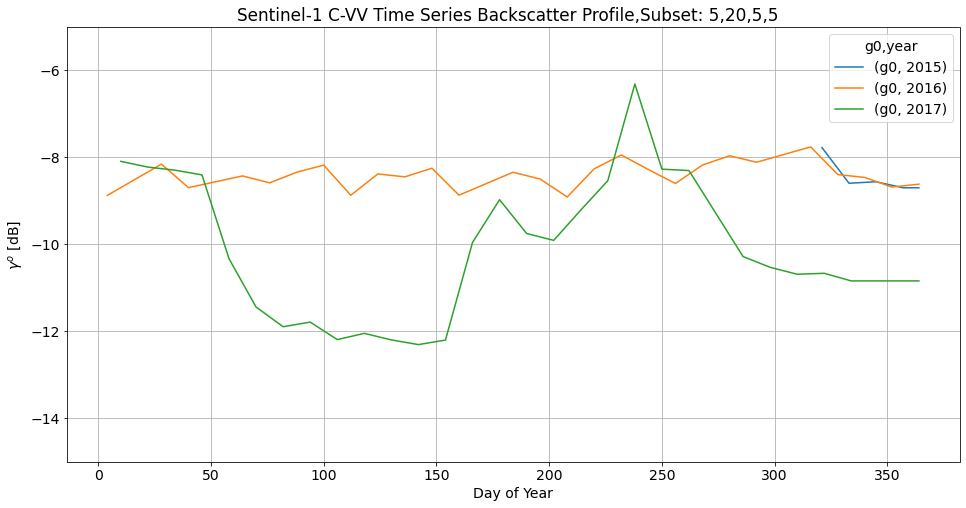

In [84]:
pivot_table_2.plot(figsize=(16, 8))
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile,\
Subset: 5,20,5,5  ')
plt.ylabel('$\gamma^o$ [dB]')
plt.xlabel('Day of Year')
_ = plt.ylim(ylim)
plt.grid()
plt.savefig('overlapping_years_time_series_backscatter_profile', dpi=72)

<br>
<hr>
<font face="Calibri" size="5"> <b> 5. Time Series Change Detection</b> </font> 

<font face="Calibri" size="3"> Now we are ready to perform efficient change detection on the time series data. We will discuss two approaches:
<ol>
    <li>Year-to-year differencing of the subsetted time series</li>
    <li>Cumulative Sum-based change detection</li>
</ol>
</font> 
<br>
<font face="Calibri" size="3"><b>Set a dB change threshold.</b></font>

In [85]:
threshold = 3

<font face="Calibri" size="3"><b>Calculate the difference between years (2016 and 2017):</b></font>

In [86]:
diff_2017_2016 = pivot_table_2.g0[2017] - pivot_table_2.g0[2016]

<hr>
<font face="Calibri" size="4"> <b> 5.1 Change Detection based on Year-to-Year Differencing </b> </font> 

<font face="Calibri" size="3"><b>Compute and plot the differences between the interpolated time series and look for change using a threshold value. Save the plot as a png (year2year_differencing_time_series.png):</b></font>

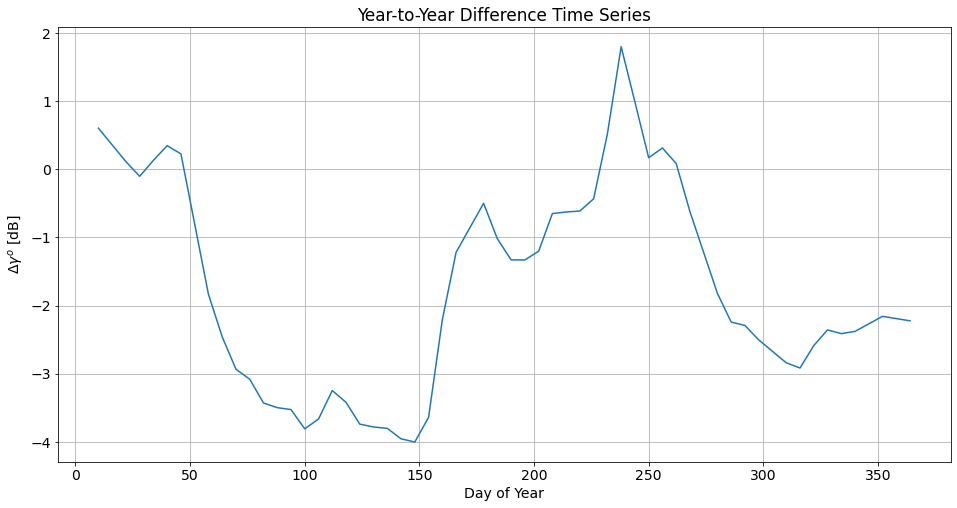

In [87]:
_ = diff_2017_2016.plot(kind='line', figsize=(16,8))
plt.title('Year-to-Year Difference Time Series')
plt.ylabel('$\Delta\gamma^o$ [dB]')
plt.xlabel('Day of Year')
plt.grid()
plt.savefig('year2year_differencing_time_series', dpi=72)

<font face="Calibri" size="3"><b>Calculate the days-of-year on which the threshold was exceeded:</b></font>

In [88]:
threshold_exceeded = diff_2017_2016[abs(diff_2017_2016) > threshold]
print(threshold_exceeded)

doy
76    -3.081974
82    -3.430615
88    -3.499177
94    -3.527523
100   -3.810760
106   -3.665967
112   -3.248034
118   -3.420952
124   -3.741039
130   -3.782975
136   -3.803250
142   -3.956439
148   -4.003891
154   -3.642117
dtype: float64


<font face="Calibri" size="3"> From the <i>threshold_exceeded</i> dataframe we can infer the first date at which the threshold was exceeded. We would label this date as a **change point**. As an additional criteria for labeling a change point, one can also consider the number of observations after an identified change point that also exceeded the threshold. If only one or two observations differed from the year before this could be considered an outlier. Additional smoothing of the time series may sometimes be useful to avoid false detections. </font>

<hr>
<font face="Calibri" size="4"> <b> 5.2 Cumulative Sums for Change Detection</b> </font> 

<font face="Calibri" size="3"> Another approach to detect change in regularly acquired data is employing the method of **cumulative sums**. Changes are determined by comparing the time series data against its mean. A full explanation and examples from the financial sector can be found at [http://www.variation.com/cpa/tech/changepoint.html](http://www.variation.com/cpa/tech/changepoint.html)
<br><br><hr>
<u><b>5.2.A First let's consider a time series and its mean observation</b></u>:<br> 
We look at two full years of observations from Sentinel-1 data for an area where we suspect change. In the following, we define $X$ as our time series
<br><br>
\begin{equation}
X = (X_1,X_2,...,X_n)
\end{equation}

with $X_i$ being the SAR backscatter values at times $i=1,...,n$ and $n$ is the number of observations in the time series.
<br><br>
<b>Create a times series of the subset and calculate the backscatter values:</b>
</font>

In [89]:
subset = (5, 20, 3, 3)
time_series_1 = timeSeries(raster_stack_pwr, time_index, subset)
backscatter_values = time_series_1[time_series_1.index>'2015-10-31']

<hr>
<font face="Calibri" size="3"> <b><u>5.2.B Filtering the time series for outliers</u></b>:<br>
It is advantageous in noisy SAR time series like those from C-Band Sentinel-1 data to reduce noise by <b>applying a filter along the time axis</b>. Pandas offers a <i>"rolling"</i> function for these purposes. Using the <i>rolling</i> function, we will apply a <i>median filter</i> to our data.</font>
<br><br>
<font face="Calibri" size="3"><b>Calculate the median backscatter values and plot them against the original values. Save the plot as a png (Original vs. Median Time Series):</b></font>

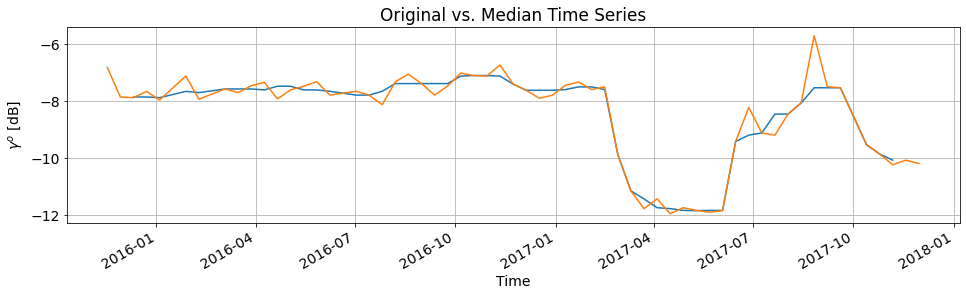

In [90]:
backscatter_values_median = backscatter_values.rolling(5, center=True).median()
fig, ax = plt.subplots(figsize=(16, 4))
backscatter_values_median.plot()
backscatter_values.plot()
plt.title('Original vs. Median Time Series')
plt.ylabel('$\gamma^o$ [dB]')
plt.xlabel('Time')
plt.grid()
plt.savefig('original_vs_median_time_series', dpi=72)

<font face="Calibri" size="3"><b>Calculate the time series' mean value and plot it against the original values. Save the plot as a png (original_time_series_vs_mean_val.png):</b></font>

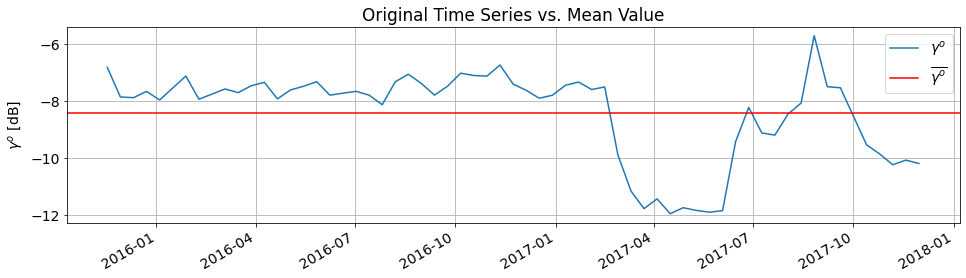

In [91]:
fig, ax = plt.subplots(figsize=(16, 4))
backscatter_values.plot()
plt.title('Original Time Series vs. Mean Value')
plt.ylabel('$\gamma^o$ [dB]')
ax.axhline(backscatter_values.mean(), color='red')
_ = plt.legend(['$\gamma^o$', '$\overline{\gamma^o}$'])
plt.grid()
plt.savefig('original_time_series_vs_mean_val', dpi=72)

<font face="Calibri" size="3"><b>Calculate the time series' mean value and plot it against the median values. Save the plot as a png (median_time_series_vs_mean_val.png):</b></font>

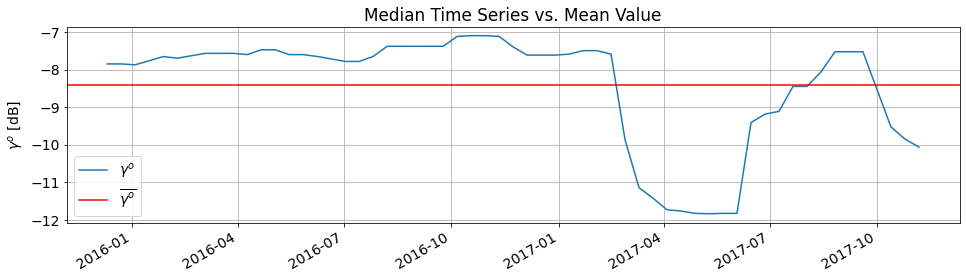

In [92]:
backscatter_values_mean = backscatter_values.mean()

fig, ax = plt.subplots(figsize=(16, 4))
backscatter_values_median.plot()
plt.title('Median Time Series vs. Mean Value')
plt.ylabel('$\gamma^o$ [dB]')
ax.axhline(backscatter_values.mean(), color='red')
_ = plt.legend(['$\gamma^o$', '$\overline{\gamma^o}$'])
plt.grid()
plt.savefig('median_time_series_vs_mean_val', dpi=72)

<hr>
<font face="Calibri" size="3"> <b><u>5.2.C Calculate the Residuals of the Time Series Against the Mean $\overline{\gamma^o}$</u></b>:<br>
To get to the residual, we calculate 

\begin{equation}
R = X_i - \overline{X}
\end{equation}</font>
<br><br>
<font face="Calibri" size="3"><b>Calculate the residuals:</b></font>

In [93]:
residuals = backscatter_values - backscatter_values_mean

<hr>
<font face="Calibri" size="3"> <b><u>5.2.D Calculate Cumulative Sum of the Residuals</u></b>:<br>
The cumulative sum is defined as: 

\begin{equation}
S = \displaystyle\sum_1^n{R_i}
\end{equation}</font>
<br><br>
<font face="Calibri" size="3"> <b>Calculate and plot the cumulative sum of the residuals. Save the plot as a png (cumulative_sum_residuals.png):</b></font>

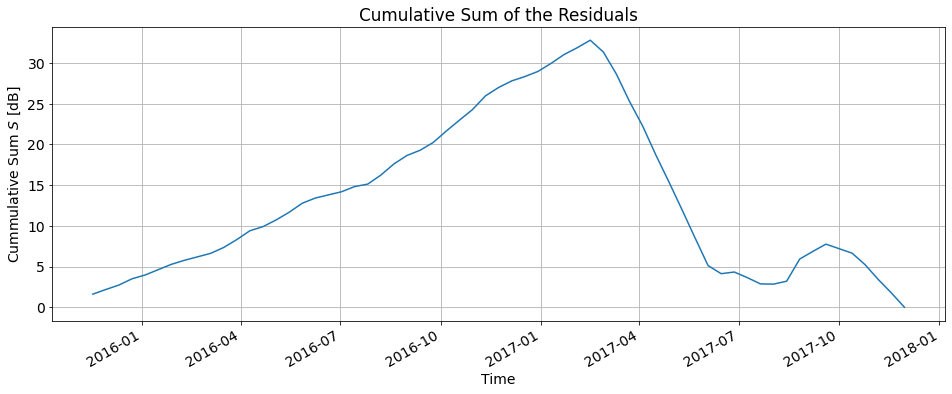

In [94]:
sums = residuals.cumsum()

_ = sums.plot(figsize=(16, 6))
plt.title('Cumulative Sum of the Residuals')
plt.ylabel('Cummulative Sum $S$ [dB]')
plt.xlabel('Time')
plt.grid()
plt.savefig('cumulative_sum_residuals', dpi=72)

<font face="Calibri" size="3"> The **cumulative sum** is a good indicator of change in the time series. An estimator for the magnitude of change is given as the difference between the maximum and minimum value of the cumulative sum $S$: 

\begin{equation}
S_{DIFF} = S_{MAX} - S_{MIN}
\end{equation}
<br><br>
<b>Calculate the magnitude of change:</b></font>

In [95]:
change_mag = sums.max() - sums.min()
print('Change magnitude: %5.3f dB' % (change_mag))

Change magnitude: 32.803 dB


<hr>
<font face="Calibri" size="3"> <b><u>5.2.E Identify Change Point in the Time Series</u></b>:<br>
A candidate change point is identified from $S$ at the time where $S_{MAX}$ is found:

\begin{equation}
T_{{CP}_{before}} = T(S_i = S_{MAX})
\end{equation}

with $T_{{CP}_{before}}$ being the timestamp of the last observation <i>before</i> the identified change point, $S_i$ is the cumulative sum of $R$ with $i=1,...n$, and $n$ is the number of observations in the time series. 

The first observation <i>after</i> a change occurred ($T_{{CP}_{after}}$) is then found as the first observation in the time series following $T_{{CP}_{before}}$.
<br><br>
<b>Calculate $T_{{CP}_{before}}$:</b>
</font>

In [96]:
change_point_before = sums[sums==sums.max()].index[0]
print('Last date before change occurred: {}'.format(change_point_before.date()))

Last date before change occurred: 2017-02-15


<font face="Calibri" size="3"><b>Calculate $T_{{CP}_{after}}$:</b></font>

In [97]:
change_point_after = sums[sums.index > change_point_before].index[0]
print('First date after change occurred: {}'.format(change_point_after.date()))

First date after change occurred: 2017-02-27


<hr>
<font face="Calibri" size="3"> <b><u>5.2.F Determine our Confidence in the Identified Change Point using Bootstrapping</u></b>:<br>
We can determine if an identified change point is indeed a valid detection by <b>randomly reordering the time series</b> and <b>comparing the various $S$ curves</b>. During this <b>"bootstrapping"</b> approach, we count how many times the $S_{DIFF}$ values are greater than $S_{{DIFF}_{random}}$ of the identified change point. 
    
After bootstrapping, we define the <b>confidence level $CL$</b> in a detected change point according to:

\begin{equation}
CL = \frac{N_{GT}}{N_{bootstraps}}
\end{equation}

where $N_{GT}$ is the number of times $S_{DIFF}$ > $S_{{DIFF}_{random}}$ and $N_{bootstraps}$ is the number of bootstraps randomizing $R$.
<br><br><br>
As another quality metric we can also calculate the <b>significance $CP_{significance}$</b> of a change point according to: 

\begin{equation}
CP_{significance} = 1 - \left( \frac{\sum_{b=1}^{N_{bootstraps}}{S_{{DIFF}_{{random}_i}}}}{N_{bootstraps}} \middle/ S_{DIFF} \right)
\end{equation}

The closer $CP_{significance}$ is to 1, the more significant the change point.</font>
<br><br>
<font face="Calibri" size="3"><b>Write a function that implements the bootstrapping algorithm:</b></font>

In [98]:
# pyplot must be imported as plt
import random
def bootstrap(n_bootstraps, name, sums, residuals, output_file=False):
    fig, ax = plt.subplots(figsize=(16,6))
    ax.set_ylabel('Cumulative Sums of the Residuals')
    change_mag_random_sum = 0
    change_mag_random_max = 0 # to keep track of the maximum change magnitude of the bootstrapped sample
    qty_change_mag_above_random = 0 # to keep track of the maxium Sdiff of the bootstrapped sample
    print("Running Bootstrapping for %4.1f iterations ..." % (n_bootstraps))
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'c', 'm', 'y', 'k', 'g']
    for i in range(n_bootstraps):
        residuals_random = residuals.sample(frac=1)  # Randomize the time steps of the residuals
        sums_random = residuals_random.cumsum()
        change_mag_random = sums_random.max() - sums_random.min()
        change_mag_random_sum += change_mag_random
        if change_mag_random > change_mag_random_max:
            change_mag_random_max = change_mag_random
        if change_mag > change_mag_random:
            qty_change_mag_above_random += 1
        sums_random.plot(ax=ax, color=random.choice(colors), label='_nolegend_')
        if ((i+1)/n_bootstraps*100) % 10 == 0:
            print("\r%4.1f percent completed ..." % ((i+1)/n_bootstraps*100), end='\r', flush=True)
    sums.plot(ax=ax, color='r', linewidth=3)
    fig.legend(['S Curve for Candidate Change Point'])
    print(f"Bootstrapping Complete")
    _ = ax.axhline(change_mag_random_sum/n_bootstraps, color='b')
    plt.grid()
    if output_file:
        plt.savefig(f"bootstrap_{name}_{n_bootstraps}", dpi=72)
        print(f"Saved plot: bootstrap_{name}_{n_bootstraps}.png")
    return [qty_change_mag_above_random, change_mag_random_sum]  

<font face="Calibri" size="3"><b>Call the bootstrap function with a sample size of 2000:</b></font>

Running Bootstrapping for 2000.0 iterations ...
Bootstrapping Completed ...
Saved plot: bootstrap__2000.png


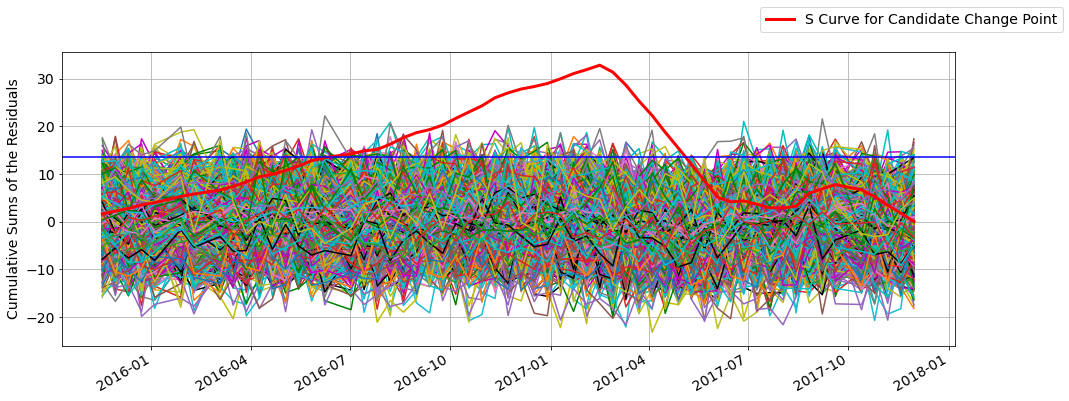

In [99]:
n_bootstraps = 2000
bootstrapped_change_mag = bootstrap(n_bootstraps, "", sums, residuals, output_file=True)

<hr>
<font face="Calibri" size="3"> Based on the bootstrapping results, we can now calculate <b>Confidence Level $CL$</b> and <b>Significance $CP_{significance}$</b> for our candidate change point.</font>
<br><br>
<font face="Calibri" size="3"><b>Calculate the confidence level:</b></font>

In [100]:
confidence_level = 1.0 * bootstrapped_change_mag[0] / n_bootstraps
print('Confidence Level for change point {} percent'.format(confidence_level*100.0))

Confidence Level for change point 100.0 percent


<font face="Calibri" size="3"><b>Calculate the change point significance:</b></font>

In [101]:
change_point_significance = 1.0 - (bootstrapped_change_mag[1]/n_bootstraps)/change_mag 
print('Change point significance metric: {}'.format(change_point_significance))

Change point significance metric: 0.5846599321035542


<hr>
<font face="Calibri" size="3"> <b><u>5.2.G TRICK: Detrending of Time Series Before Change Detection to Improve Robustness</u></b>:<br>
De-trending the time series with global image means improves the robustness of change point detection as global image time series anomalies stemming from calibration or seasonal trends are removed prior to time series analysis. This de-trending needs to be performed with large subsets so real change is not influencing the image statistics. 

NOTE: Due to the small size of our subset, we will see some distortions when we detrend the time series.

<b>Let's start by building a global image means time series and plot the global means. Save the plot as a png (global_means_time_series.png):</b>
</font>

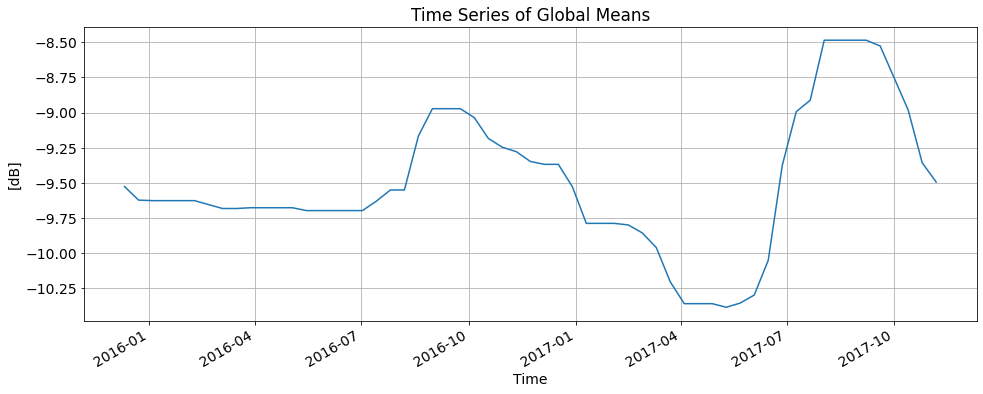

In [102]:
means_pwr = np.mean(raster_stack_pwr, axis=(1, 2))
means_dB = 10.0 * np.log10(means_pwr)
global_means_ts = pd.Series(means_dB, index=time_index)
global_means_ts = global_means_ts[global_means_ts.index > '2015-10-31'] # filter dates
global_means_ts = global_means_ts.rolling(5, center=True).median()
global_means_ts.plot(figsize=(16, 6))
plt.title('Time Series of Global Means')
plt.ylabel('[dB]')
plt.xlabel('Time')
plt.grid()
plt.savefig(f"global_means_time_series", dpi=72)

<font face="Calibri" size="3"><b>Compare the time series of global means (above) to the time series of our small subset (below):</b>
</font>

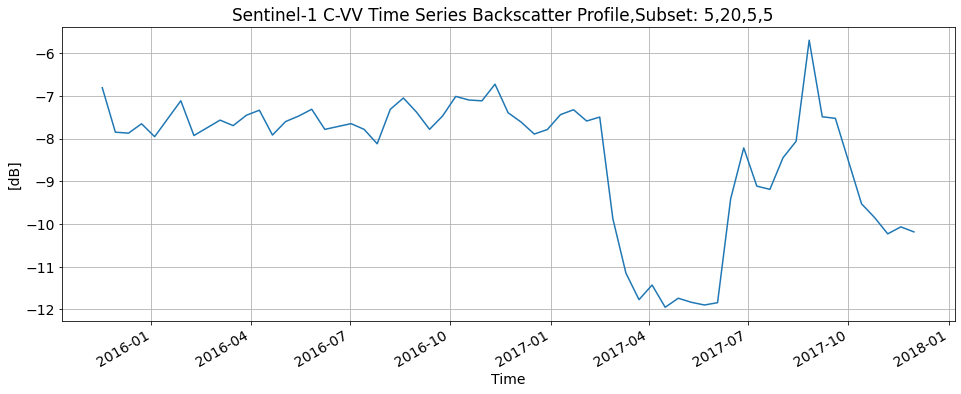

In [103]:
backscatter_values.plot(figsize=(16, 6))
plt.title('Sentinel-1 C-VV Time Series Backscatter Profile,\
Subset: 5,20,5,5  ')
plt.ylabel('[dB]')
plt.xlabel('Time')
plt.grid()

<font face="Calibri" size="3"> There are some signatures of the global seasonal trend in our subset time series. To remove these signatures and get a cleaner time series of change, we subtract the global mean time series from our subset time series.</font>
<br><br>
<font face="Calibri" size="3"><b>De-trend the subset and re-plot the backscatter profile. Save the plot (detrended_time_series.png):</b></font>

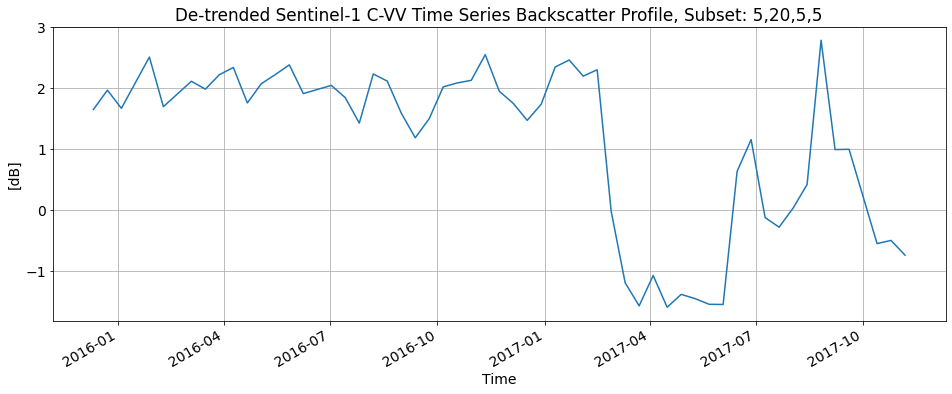

In [104]:
backscatter_minus_seasonal = backscatter_values - global_means_ts
backscatter_minus_seasonal.plot(figsize=(16, 6))
plt.title('De-trended Sentinel-1 C-VV Time Series Backscatter Profile, Subset: 5,20,5,5')
plt.ylabel('[dB]')
plt.xlabel('Time')
plt.grid()
plt.savefig(f"detrended_time_series", dpi=72)

<font face="Calibri" size="3"><b>Save a plot comparing the original, global means, and detrended time-series (globalMeans_original_detrended_time_series.png):</b></font>

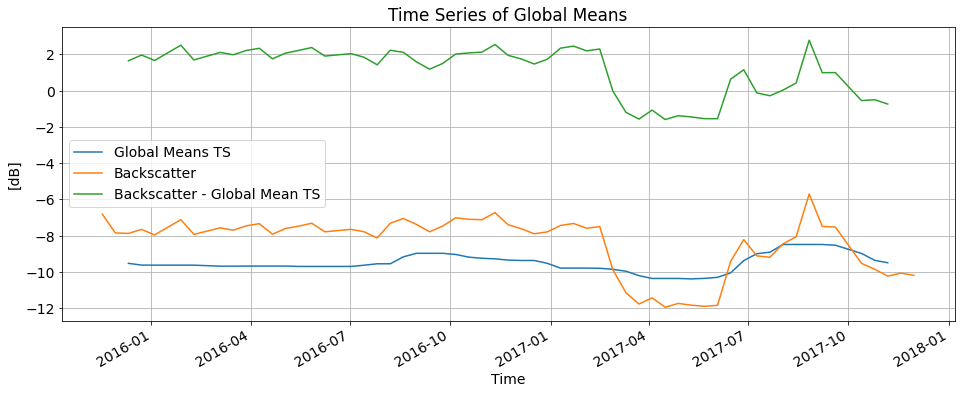

In [105]:
means_pwr = np.mean(raster_stack_pwr, axis=(1, 2))
means_dB = 10.0 * np.log10(means_pwr)
global_means_ts = pd.Series(means_dB, index=time_index)
global_means_ts = global_means_ts[global_means_ts.index > '2015-10-31'] # filter dates
global_means_ts = global_means_ts.rolling(5, center=True).median()
global_means_ts.plot(figsize=(16, 6))
backscatter_values.plot(figsize=(16, 6))
backscatter_minus_seasonal = (backscatter_values - global_means_ts)
backscatter_minus_seasonal.plot(figsize=(16, 6))
plt.title('Time Series of Global Means')
plt.ylabel('[dB]')
plt.xlabel('Time')
plt.legend(['Global Means TS', 'Backscatter', 'Backscatter - Global Mean TS'], loc='best')
plt.grid()
plt.savefig(f"globalMeans_original_detrended_time_series", dpi=72)

<font face="Calibri" size="3"><b>Recalculate and plot the residuals based on the de-trended data</b></font>

In [106]:
residuals = backscatter_minus_seasonal - backscatter_values_mean

<font face="Calibri" size="3"><b>Compute, plot, and save the cumulative sum of the detrended time series (cumualtive_sum_detrended_time_series.png):</b></font>

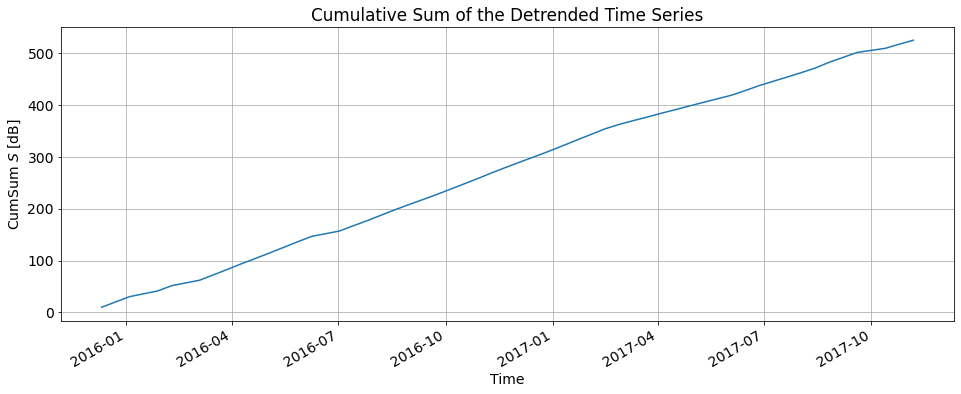

In [107]:
sums = residuals.cumsum()
_ = sums.plot(figsize=(16, 6))
plt.title("Cumulative Sum of the Detrended Time Series")
plt.ylabel('CumSum $S$ [dB]')
plt.xlabel('Time')
plt.grid()
plt.savefig(f"cumualtive_sum_detrended_time_series", dpi=72)

<font face="Calibri" size="3"><b>Detect Change Point and extract related change dates:</b></font>

In [108]:
detrended_change_point_before = sums[sums==sums.max()].index[0]
print('Last date before change occurred: {}'.format(detrended_change_point_before.date()))

detrended_change_point_after = sums[sums.index > detrended_change_point_before].index[0]
print('First date after change occurred: {}'.format(detrended_change_point_after.date()))

Last date before change occurred: 2017-11-06
First date after change occurred: 2017-11-18


<font face="Calibri" size="3"><b>Perform bootstrapping:</b></font>

Running Bootstrapping for 2000.0 iterations ...
Bootstrapping Completed ...
Saved plot: bootstrap_detrended_2000.png


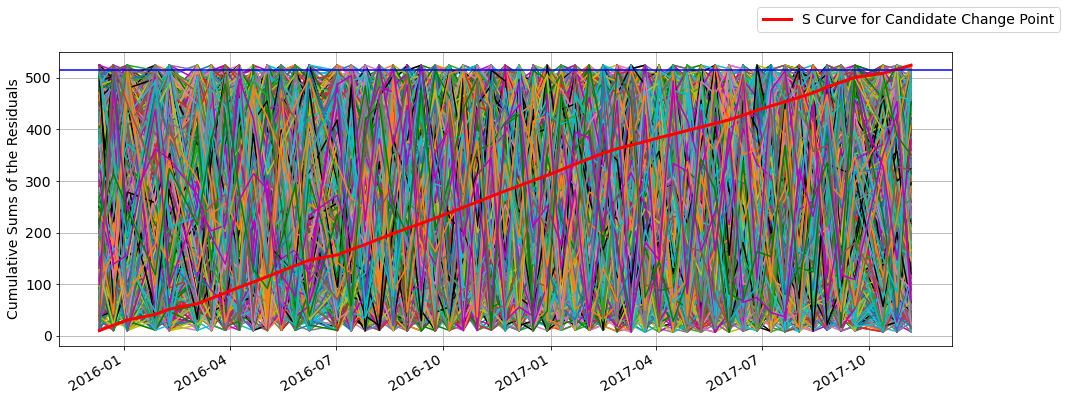

In [109]:
n_bootstraps = 2000
bootstrapped_change_mag = bootstrap(n_bootstraps, "detrended", sums, residuals, output_file=True)

<font face="Calibri" size="3"><b>Calculate the confidence level:</b></font>

In [110]:
detrended_confidence_level = bootstrapped_change_mag[0] / n_bootstraps
print('Confidence Level for change point {} percent'.format(confidence_level*100.0))

Confidence Level for change point 100.0 percent


<hr>
<font face="Calibri" size="3">Note how the <b>change point significance $CP_{significance}$</b> has increased in the detrended time series:
</font>

In [111]:
detrended_change_point_significance = 1.0 - (bootstrapped_change_mag[1]/n_bootstraps) / change_mag 
print('Change point significance metric: {}'.format(change_point_significance))

Change point significance metric: 0.5846599321035542


<br>
<hr>
<font face="Calibri" size="5"> <b> 6. Cumulative Sum-based Change Detection Across an Entire Image</b> </font> 

<font face="Calibri" size="3"> With numpy arrays we can apply the concept of **cumulative sum change detection** analysis effectively on the entire image stack. We take advantage of array slicing and axis-based computing in numpy. Axis 0 is the time domain in our raster stacks.
    
<hr>
<font size="4"><b>6.1 We first create our time series stack:</b></font> 
<br><br>
<font size="3"><b>Filter out the first layer (Dates >= '2015-11-1'):</b></font>

In [112]:
raster_stack = raster_stack_pwr
raster_stack_sub = raster_stack_pwr[1:, :, :]
time_index_sub = time_index[1:]

<font size="3"><b>Run the following code cell <u>if</u> you wish to change to dB scale:</b></font>

In [113]:
raster_stack = 10.0 * np.log10(raster_stack_sub)

<font size="3"><b>Plot and save Band-1 (band_1.png):</b></font>

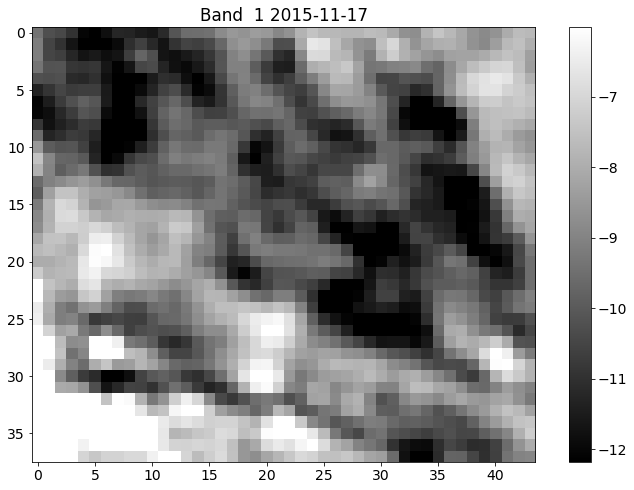

In [114]:
plt.figure(figsize=(12, 8))
band_number = 0
vmin = np.percentile(raster_stack[band_number], 5)
vmax = np.percentile(raster_stack[band_number], 95)
plt.title('Band  {} {}'.format(band_number+1, time_index_sub[band_number].date()))
plt.imshow(raster_stack[0], cmap='gray', vmin=vmin, vmax=vmax)
_ = plt.colorbar()
plt.savefig('band_1.png', dpi=300, transparent='true')

<font size="3"><b>Save the plot as a GeoTiff (band_1.tiff):</b></font>

In [115]:
%%capture
geotiff_from_plot(raster_stack[0], 'band_1', coords, utm_zone, cmap='gray', dpi=600)

<br>
<hr>
<font face="Calibri" size="4"> <b> 6.2 Calculate Mean Across Time Series to Prepare for Calculation of Cumulative Sum $S$:</b> </font> 
<br><br>
<font face="Calibri" size="3"> <b>Plot and save the the raster stack mean (raster_stack_mean.png):</b></font>

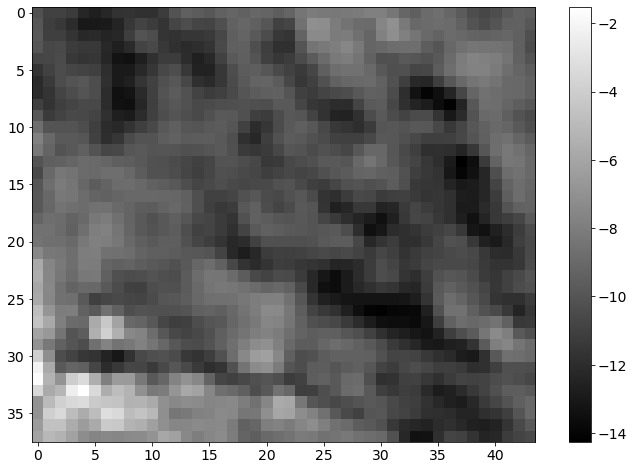

In [116]:
raster_stack_mean = np.mean(raster_stack, axis=0)
plt.figure(figsize=(12, 8))
plt.imshow(raster_stack_mean, cmap='gray')
_ = plt.colorbar()
plt.savefig('raster_stack_mean.png', dpi=300, transparent='true')

<font size="3"><b>Save the raster stack mean as a GeoTiff (raster_stack_mean.tiff):</b></font>

In [117]:
%%capture
geotiff_from_plot(raster_stack_mean, 'raster_stack_mean', coords, utm_zone, cmap='gray', dpi=600)

<font face="Calibri" size="3"><b>Calculate the residuals:</b></font>

In [118]:
residuals = raster_stack - raster_stack_mean

<font face="Calibri" size="3"><b>Close img, as it is no longer needed in the notebook:</b></font> 

In [119]:
radar_stack = None

<font face="Calibri" size="3"><b>Plot and save the residuals for band 1 (residuals_band_1.png):</b></font>

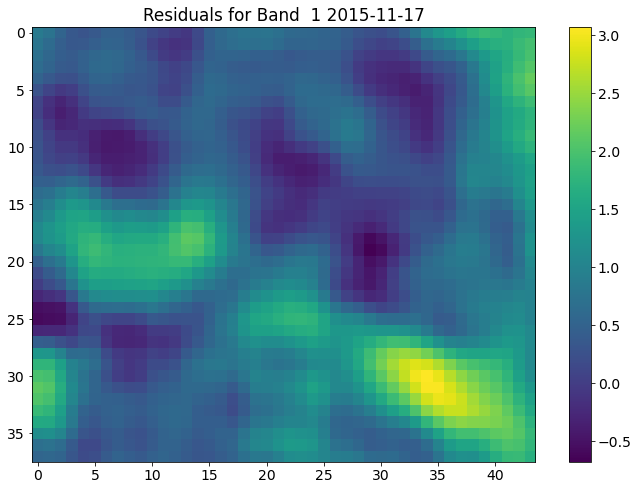

In [120]:
plt.figure(figsize=(12, 8))
plt.imshow(residuals[0])
plt.title('Residuals for Band  {} {}'.format(band_number+1, time_index_sub[band_number].date()))
_ = plt.colorbar()
plt.savefig('residuals_band_1', dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the residuals for band 1 as a GeoTiff (residuals_band_1.tiff):</b></font>

In [121]:
%%capture
geotiff_from_plot(residuals[0], 'residuals_band_1', coords, utm_zone, dpi=600)

<br>
<hr>
<font face="Calibri" size="4"> <b> 6.3 Calculate Cumulative Sum $S$ as well as Change Magnitude $S_{diff}$:</b> </font> 
<br><br>
<font face="Calibri" size="3"><b>Plot and save the cumulative sum max, min, and change magnitude (Smax_Smin_Sdiff.png):</b></font>

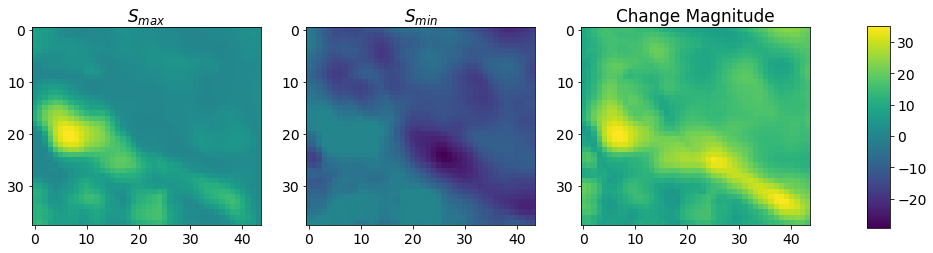

In [122]:
sums = np.cumsum(residuals, axis=0)
sums_max = np.max(sums, axis=0)
sums_min = np.min(sums, axis=0)
change_mag = sums_max - sums_min
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
vmin = sums_min.min()
vmax = sums_max.max()
sums_max_plot = ax[0].imshow(sums_max, vmin=vmin, vmax=vmax)
ax[0].set_title('$S_{max}$')
ax[1].imshow(sums_min, vmin=vmin, vmax=vmax)
ax[1].set_title('$S_{min}$')
ax[2].imshow(change_mag, vmin=vmin, vmax=vmax)
ax[2].set_title('Change Magnitude')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
_ = fig.colorbar(sums_max_plot, cax=cbar_ax)
plt.savefig('Smax_Smin_Sdiff', dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save Smax as a GeoTiff (Smax.tiff):</b></font>

In [123]:
%%capture
geotiff_from_plot(sums_max, 'Smax', coords, utm_zone, vmin=vmin, vmax=vmax)

<font face="Calibri" size="3"><b>Save Smin as a GeoTiff (Smin.tiff):</b></font>

In [124]:
%%capture
geotiff_from_plot(sums_min, 'Smin', coords, utm_zone, vmin=vmin, vmax=vmax)

<font face="Calibri" size="3"><b>Save the change magnitude as a GeoTiff (Sdiff.tiff):</b></font>

In [125]:
%%capture
geotiff_from_plot(change_mag, 'Sdiff', coords, utm_zone, vmin=vmin, vmax=vmax)

<br>
<hr>
<font face="Calibri" size="4"> <b> 6.4 Mask $S_{diff}$ With a-priori Threshold To Idenfity Change Candidate Pixels:</b> </font>

<font face="Calibri" size="3">To identified change candidate pixels, we can threshold $S_{diff}$ to reduce computation of the bootstrapping. For land cover change we would not expect more than 5-10% change pixels in a landscape. So, if the test region is reasonably large, setting a threshold for expected change to 10% is appropriate. In our example we'll start out with a very conservative threshold of 20%.

<b>Plot and save the histogram for the change magnitude and the change magnitude cumulative distribution function (Sdiff_histogram_CDF.png):</b></font>

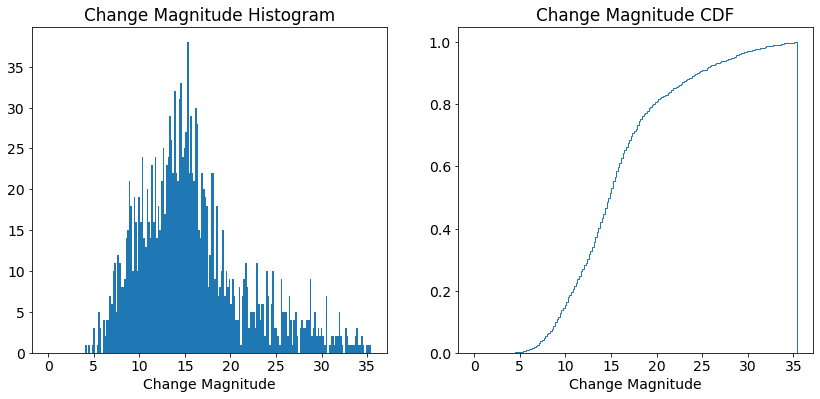

In [126]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(14, 6)) # Initialize figure with a size
ax1 = fig.add_subplot(121)  # 121 determines: 2 rows, 2 plots, first plot
ax2 = fig.add_subplot(122)
# Second plot: Histogram
# IMPORTANT: To get a histogram, we first need to *flatten* 
# the two-dimensional image into a one-dimensional vector.
histogram = ax1.hist(change_mag.flatten(), bins=200, range=(0, np.max(change_mag)))
ax1.xaxis.set_label_text('Change Magnitude')
ax1.set_title('Change Magnitude Histogram')
plt.grid()
n, bins, patches = ax2.hist(change_mag.flatten(), bins=200, range=(0, np.max(change_mag)), cumulative='True', density='True', histtype='step', label='Empirical')
ax2.xaxis.set_label_text('Change Magnitude')
ax2.set_title('Change Magnitude CDF')
plt.grid()
plt.savefig('Sdiff_histogram_CDF', dpi=72, transparent='true')

<font face="Calibri" size="3">Using this threshold, we can create a plot to <b>visualize our change candidate areas. Save the plot (change_candidate.png):</b></font>

At the 80.0% percentile, the threshold value is 19.64


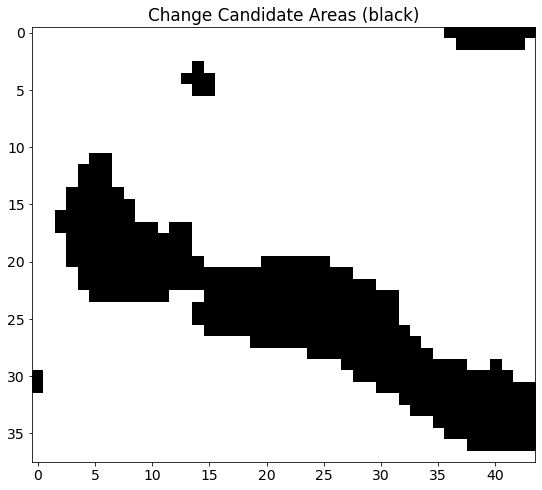

In [127]:
precentile = 0.8
out_indicies = np.where(n>precentile)
threshold_indicies = np.min(out_indicies)
threshold = bins[threshold_indicies]
print('At the {}% percentile, the threshold value is {:2.2f}'.format(precentile*100,threshold))

change_mag_mask = change_mag < threshold
plt.figure(figsize=(12, 8))
plt.title('Change Candidate Areas (black)')
_ = plt.imshow(change_mag_mask, cmap='gray')
plt.savefig('change_candidate', dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the change candidate plot as a GeoTiff (change_candidate.tiff):</b></font>

In [128]:
%%capture
geotiff_from_plot(change_mag_mask, 'change_candidate', coords, utm_zone, cmap='gray')

<br>
<hr>
<font face="Calibri" size="4"> <b> 6.5 Bootstrapping to Prepare for Change Point Selection:</b> </font>

<font face="Calibri" size="3">We can now perform bootstrapping over the candidate pixels. The workflow is as follows:
<ul>
    <li>Filter our residuals to the change candidate pixels</li>
    <li>Perform bootstrapping over candidate pixels</li>
</ul>
<br>
<b>For efficient computing we <b>permutate the index of the time axis:</b></font>

In [129]:
residuals_mask = np.broadcast_to(change_mag_mask, residuals.shape)
residuals_masked = np.ma.array(residuals, mask=residuals_mask)

<font face="Calibri" size="3">On the masked time series stack of residuals, we can <b>re-compute the cumulative sums:</b></font>

In [130]:
sums_masked = np.ma.cumsum(residuals_masked, axis=0)

<font face="Calibri" size="3"><b>Plot the min sums, max sums, and change magnitude of the masked subset (masked_Smax_Smin_Sdiff.png):</b></font>

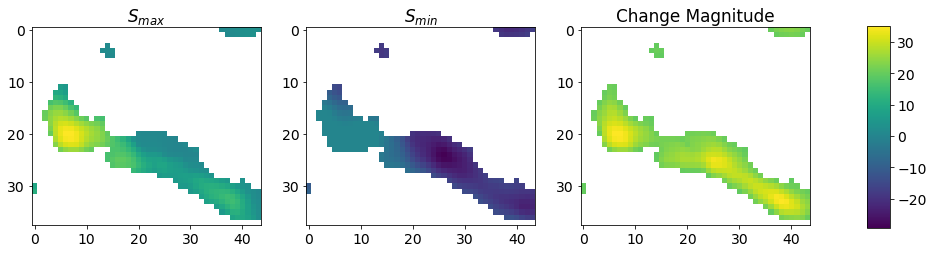

In [131]:
sums_masked_max = np.ma.max(sums_masked, axis=0)
sums_masked_min = np.ma.min(sums_masked, axis=0)
change_mag = sums_masked_max - sums_masked_min
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
vmin = sums_masked_min.min()
vmax = sums_masked_max.max()
sums_masked_max_plot = ax[0].imshow(sums_masked_max, vmin=vmin, vmax=vmax)
ax[0].set_title('$S_{max}$')
ax[1].imshow(sums_masked_min, vmin=vmin, vmax=vmax)
ax[1].set_title('$S_{min}$')
ax[2].imshow(change_mag, vmin=vmin, vmax=vmax)
ax[2].set_title('Change Magnitude')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
_ = fig.colorbar(sums_masked_max_plot, cax=cbar_ax)
plt.savefig('masked_Smax_Smin_Sdiff', dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the Smax of the masked subset as a GeoTiff (masked_Smax.tiff):</b></font>

In [132]:
%%capture
geotiff_from_plot(sums_masked_max, 'masked_Smax', coords, utm_zone, vmin=vmin, vmax=vmax)

<font face="Calibri" size="3"><b>Save the Smin of the masked subset as a GeoTiff (masked_Smin.tiff):</b></font>

In [133]:
%%capture
geotiff_from_plot(sums_masked_min, 'masked_Smin', coords, utm_zone, vmin=vmin, vmax=vmax)

<font face="Calibri" size="3"><b>Save the change magnitude of the masked subset as a GeoTiff (masked_Sdiff.tiff):</b></font>

In [134]:
%%capture
geotiff_from_plot(change_mag, 'masked_Sdiff', coords, utm_zone, vmin=vmin, vmax=vmax)

<font face="Calibri" size="3"><b>Perform bootstrapping:</b>:
</font>

In [135]:
random_index = np.random.permutation(residuals_masked.shape[0])
residuals_random = residuals_masked[random_index,:,:]
n_bootstraps = 2000  # bootstrap sample size
# to keep track of the maxium Sdiff of the bootstrapped sample:
change_mag_random_max = np.ma.copy(change_mag) 
change_mag_random_max[~change_mag_random_max.mask] = 0
# to compute the Sdiff sums of the bootstrapped sample:
change_mag_random_sum = np.ma.copy(change_mag) 
change_mag_random_sum[~change_mag_random_max.mask] = 0
# to keep track of the count of the bootstrapped sample
qty_change_mag_above_random = change_mag_random_sum
qty_change_mag_above_random[~qty_change_mag_above_random.mask] = 0
print("Running Bootstrapping for %4.1f iterations ..." % (n_bootstraps))
for i in range(n_bootstraps):
    # For efficiency, we shuffle the time axis index and use that 
    #to randomize the masked array
    random_index = np.random.permutation(residuals_masked.shape[0])
    # Randomize the time step of the residuals
    residuals_random = residuals_masked[random_index, :, :]  
    sums_random = np.ma.cumsum(residuals_random, axis=0)
    sums_random_max = np.ma.max(sums_random, axis=0)
    sums_random_min = np.ma.min(sums_random, axis=0)
    change_mag_random = sums_random_max - sums_random_min
    change_mag_random_sum += change_mag_random
    change_mag_random_max[np.ma.greater(change_mag_random, change_mag_random_max)] = \
    change_mag_random[np.ma.greater(change_mag_random, change_mag_random_max)]
    qty_change_mag_above_random[np.ma.greater(change_mag, change_mag_random)] += 1
    if ((i+1)/n_bootstraps*100)%10 == 0:
        print("\r%4.1f percent completed ..." % ((i+1)/n_bootstraps*100), end='\r', flush=True)
print(f"Bootstrapping Complete.      ")

Running Bootstrapping for 2000.0 iterations ...
Bootstrapping Complete.      


<br>
<hr>
<font face="Calibri" size="4"> <b> 6.6 Extract Confidence Metrics and Select Final Change Points:</b> </font>

<font face="Calibri" size="3">We first <b>compute for all pixels the confidence level $CL$, the change point significance metric $CP_{significance}$ and the product of the two as our confidence metric for identified change points. Plot and save them (confidence_change_point.png):</b></font>

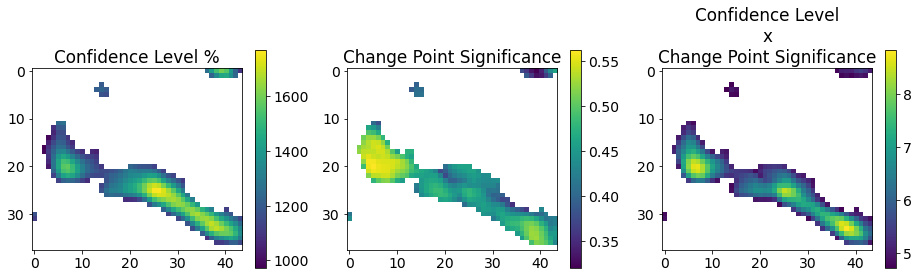

In [136]:
confidence_level = qty_change_mag_above_random / n_bootstraps
change_point_significance = 1.0 - (change_mag_random_sum/n_bootstraps) / change_mag 
#Plot
fig, ax = plt.subplots(1, 3 ,figsize=(16, 4))
a = ax[0].imshow(confidence_level*100)
fig.colorbar(a, ax=ax[0])
ax[0].set_title('Confidence Level %')
a = ax[1].imshow(change_point_significance)
fig.colorbar(a, ax=ax[1])
ax[1].set_title('Change Point Significance')
a = ax[2].imshow(confidence_level*change_point_significance)
fig.colorbar(a, ax=ax[2])
_ = ax[2].set_title('Confidence Level\nx\nChange Point Significance')
plt.savefig('confidence_change_point', dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the confidence level of the masked subset as a GeoTiff (confidence_level.tiff):</b></font>

In [137]:
%%capture
geotiff_from_plot(confidence_level*100, 'confidence_level', coords, utm_zone)

<font face="Calibri" size="3"><b>Save the change point significance of the masked subset as a GeoTiff (change_point.tiff):</b></font>

In [138]:
%%capture
geotiff_from_plot(change_point_significance, 'change_point', coords, utm_zone)

<font face="Calibri" size="3"><b>Save the confidence level x change point significance of the masked subset as a GeoTiff (CL_x_CP.tiff):</b></font>

In [139]:
%%capture
geotiff_from_plot(confidence_level*change_point_significance, 'CL_x_CP', coords, utm_zone)

<font face="Calibri" size="3"><b>Set a change point threshold of 5:</b></font>

In [140]:
change_point_threshold = 5

<font face="Calibri" size="3"><b>Create and save a plot showing the final change points (change_point_thresh.png):</b></font>

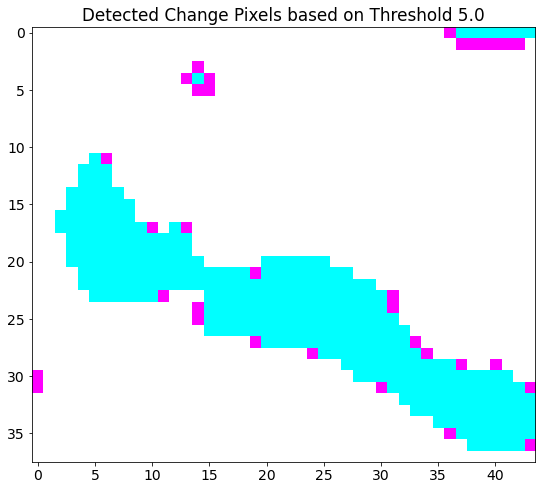

In [141]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
plt.title('Detected Change Pixels based on Threshold %2.1f' % (change_point_threshold))
a = ax.imshow(confidence_level*change_point_significance < change_point_threshold, cmap='cool')
plt.savefig('change_point_thresh', dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the thresholded change point significance of the masked subset as a GeoTiff (change_point_thresh.tiff):</b></font>

In [142]:
%%capture
geotiff_from_plot(confidence_level*change_point_significance < change_point_threshold, 
                  'change_point_thresh', coords, utm_zone, cmap='cool')

<br>
<hr>
<font face="Calibri" size="4"> <b> 6.7 Derive Timing of Change for Each Change Pixel:</b> </font>

<font face="Calibri" size="3">Our last step in the identification of the change points is to extract the timing of the change. We will produce a raster layer that shows the band number of the first date after a change was detected. We will make use of the numpy indexing scheme.</font>
<br><br>
<font face="Calibri" size="3"><b>Create a combined mask of the first threshold and the identified change points after the bootstrapping:</b></font>

In [143]:
# make a mask of our change points from the new threhold and the previous mask
change_point_mask = np.ma.mask_or(confidence_level*change_point_significance<change_point_threshold, 
                                  confidence_level.mask)
# Broadcast the mask to the shape of the masked S curves
change_point_mask2 = np.broadcast_to(change_point_mask, sums_masked.shape)
# Make a numpy masked array with this mask
change_point_raster = np.ma.array(sums_masked.data, mask=change_point_mask2)

<font face="Calibri" size="3">To retrieve the dates of the change points we <b>find the band indices in the time series along the time axis where the maximum of the cumulative sums was located.</b> Numpy offers the "argmax" function for this purpose.
</font>

In [144]:
change_point_index = np.ma.argmax(np.abs(change_point_raster), axis=0)
change_indices = list(np.unique(change_point_index))
change_indices.remove(0)
print(f"Change Indicies:\n{change_indices}")
# Look up the dates from the indices to get the change dates
all_dates = time_index[time_index>'2015-10-31']
change_dates = [str(all_dates[x].date()) for x in change_indices]
print(f"\nChange Dates:\n{change_dates}")

Change Indicies:
[32, 33, 34, 35, 36, 37, 39, 44, 45, 46, 47, 48]

Change Dates:
['2017-01-10', '2017-01-22', '2017-02-03', '2017-02-15', '2017-02-27', '2017-03-11', '2017-04-04', '2017-06-03', '2017-06-15', '2017-06-27', '2017-07-09', '2017-07-21']


<font face="Calibri" size="3"><b>Plot the change dates using the change point index raster and save it as a png (change_dates.png):</b></font>

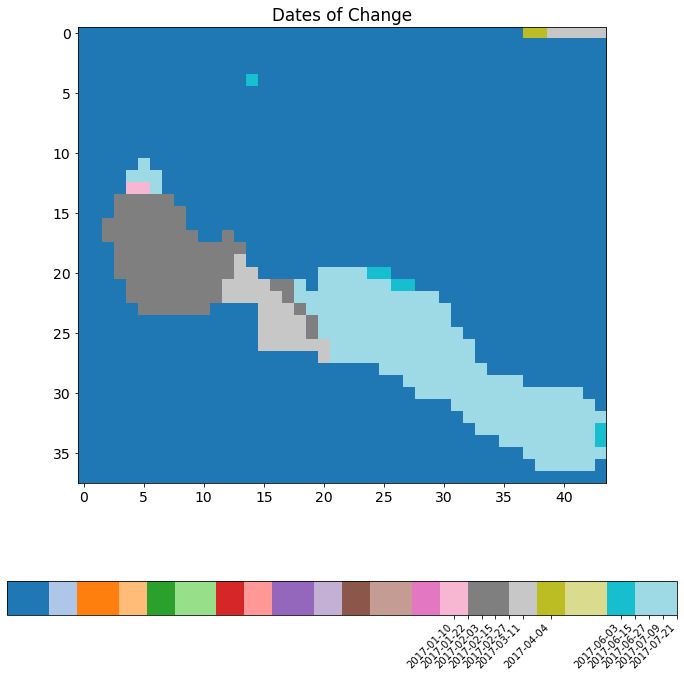

In [145]:
ticks = change_indices
tick_labels = change_dates

cmap = plt.cm.get_cmap('tab20',ticks[-1])
fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.imshow(change_point_index, interpolation='nearest', cmap=cmap)

ax.set_title('Dates of Change')
cbar = fig.colorbar(cax, ticks=ticks, orientation='horizontal')
_ = cbar.ax.set_xticklabels(tick_labels, size=10, rotation=45, ha='right')
plt.savefig('change_dates', dpi=300, transparent='true')

<font face="Calibri" size="3"><b>Save the Dates of Change plot as a GeoTiff (change_dates.tiff):</b>
<br>
Note: The GeoTiff does not include a colorbar. Date/color correlations can be identified in change_dates.png.
</font>

In [146]:
%%capture
geotiff_from_plot(change_point_index, 'change_dates', coords, utm_zone, interpolation='nearest', cmap=cmap)

<font face="Calibri" size="2"> <i>Change_Detection_Amplitude_Time_Series_Example.ipynb - Version 1.3.1 - September 2021 </i>
    <br>
    <b>Version Changes</b>
    <ul>
        <li>Replaced `os` module with `pathlib` to minimize directory changes</li>
    </ul>
</font>